<a href="https://colab.research.google.com/github/BernTomaz/Sistema-de-recomendacao/blob/main/Sistema_de_recomendacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
Imagem selecionada: carro1.jpg
Imagens recomendadas (Baseado em conteúdo):
carro3.png (Similaridade: 0.8502)
carro4.jpg (Similaridade: 0.8013)
carro2.jpg (Similaridade: 0.7913)
Usuário selecionado: 1
Imagens recomendadas (Filtragem Colaborativa):
carro2.jpg (Score: 1.1708)
carro1.jpg (Score: 0.7236)
carro3.png (Score: 0.4472)
carro4.jpg (Score: -0.7236)


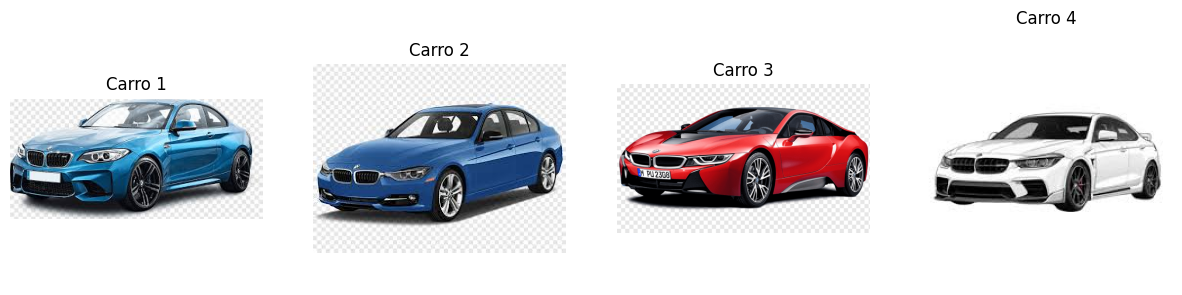

In [ ]:

import os
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

image_folder = 'carros'
image_files = ['carro1.jpg', 'carro2.jpg', 'carro3.png', 'carro4.jpg']


model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')


def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array


features = []
for img_file in image_files:
    img_path = os.path.join(image_folder, img_file)
    try:
        img_array = load_and_preprocess_image(img_path)
        feature_vector = model.predict(img_array)
        features.append(feature_vector.flatten())
    except FileNotFoundError:
        print(f"Arquivo não encontrado: {img_path}")

features = np.array(features)


similarity_matrix = cosine_similarity(features)


user_interactions = np.array([
    [1, 1, 0, -1],  # Usuário 1 gostou do carro1 e carro2, não gostou do carro4
    [0, 1, 1, 0],   # Usuário 2 gostou do carro2 e carro3
    [1, 0, 0, 1],   # Usuário 3 gostou do carro1 e carro4
    [0, 1, -1, 1],  # Usuário 4 gostou do carro2 e carro4, não gostou do carro3
])


svd = TruncatedSVD(n_components=2)
user_features = svd.fit_transform(user_interactions)
car_features = svd.components_.T


def recommend_collaborative(user_index, user_features, car_features, image_files):
    predicted_scores = np.dot(user_features[user_index], car_features.T)
    recommended_indices = np.argsort(predicted_scores)[::-1]

    print(f"Usuário selecionado: {user_index + 1}")
    print("Imagens recomendadas (Filtragem Colaborativa):")
    for idx in recommended_indices:
        print(f"{image_files[idx]} (Score: {predicted_scores[idx]:.4f})")


def recommend_similar_images(selected_index, similarity_matrix, image_files):
    similarity_scores = list(enumerate(similarity_matrix[selected_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    print(f"Imagem selecionada: {image_files[selected_index]}")
    print("Imagens recomendadas (Baseado em conteúdo):")

    for idx, score in similarity_scores[1:]:
        print(f"{image_files[idx]} (Similaridade: {score:.4f})")

# --- Recomendações ---
selected_index = 0  # carro1
recommend_similar_images(selected_index, similarity_matrix, image_files)  # Filtragem baseada em conteúdo

user_index = 0  # Usuário 1
recommend_collaborative(user_index, user_features, car_features, image_files)  # Filtragem colaborativa

# --- Visualização das imagens ---
fig, axes = plt.subplots(1, len(image_files), figsize=(15, 5))
for i, img_file in enumerate(image_files):
    img_path = os.path.join(image_folder, img_file)
    try:
        img = image.load_img(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'Carro {i+1}')
    except FileNotFoundError:
        axes[i].text(0.5, 0.5, 'Imagem não encontrada', fontsize=12, ha='center')
        axes[i].axis('off')
plt.show()
